In [5]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method

Using device: cpu
Files already downloaded and verified
Loaded 1000 test images.
Loading cifar10_resnet20 model from Torch Hub...


Using cache found in C:\Users\mtm30/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Model wrapped in ART PyTorchClassifier.

Generating adversarial examples using FGSM...
Generating adversarial examples using PGD...


Generating adversarial examples using Carlini & Wagner (L2)...


C&W L_2: 100%|██████████| 200/200 [1:23:08<00:00, 24.94s/it]


Adversarial examples generated.

Evaluating model performance:
Accuracy on clean examples: 91.70%
Accuracy on FGSM adversarial examples: 18.90%
Accuracy on PGD adversarial examples: 4.30%
Accuracy on C&W adversarial examples: 29.50%

=== SUMMARY OF RESULTS ===
Model: cifar10_resnet20
Clean Accuracy: 91.70%
FGSM Attack Accuracy: 18.90%
PGD Attack Accuracy: 4.30%
C&W Attack Accuracy: 29.50%


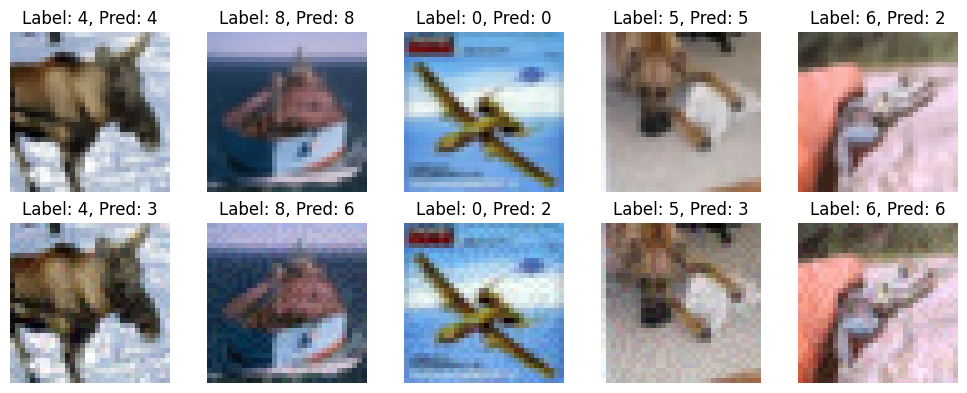

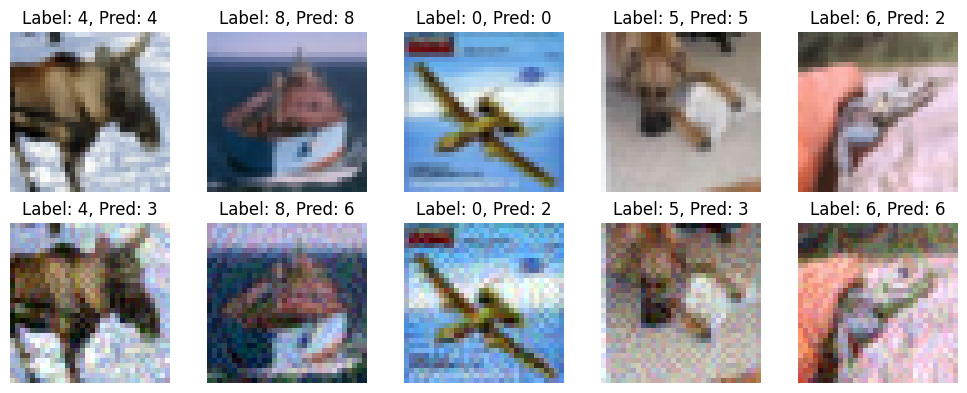

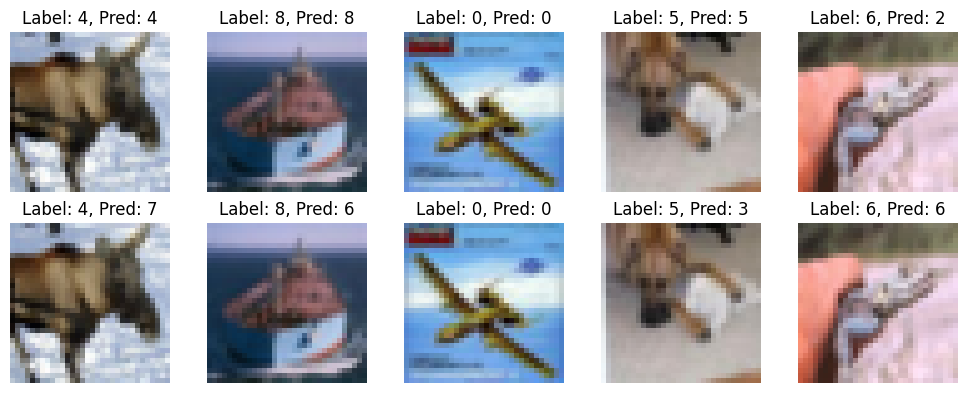

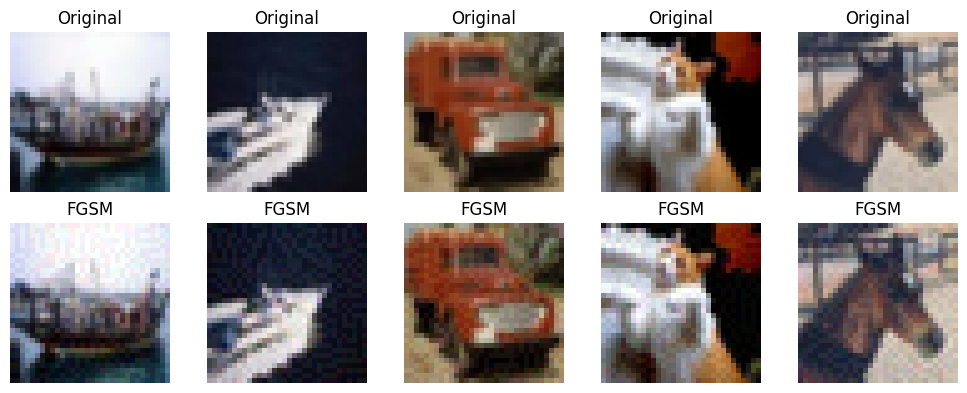

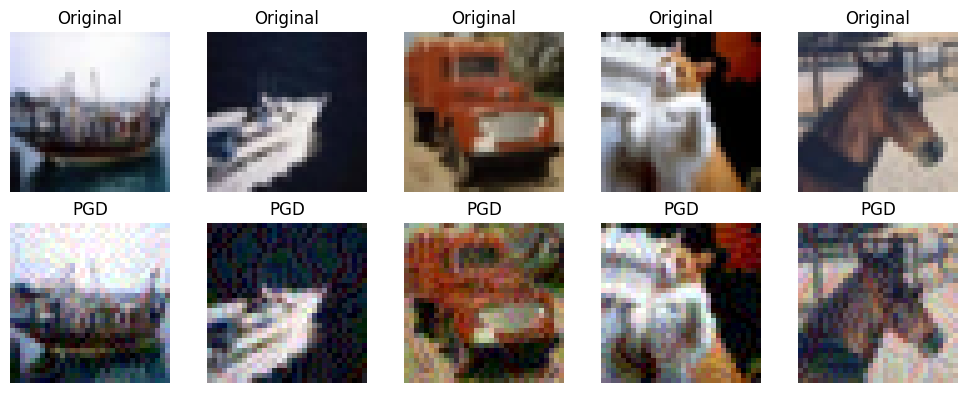

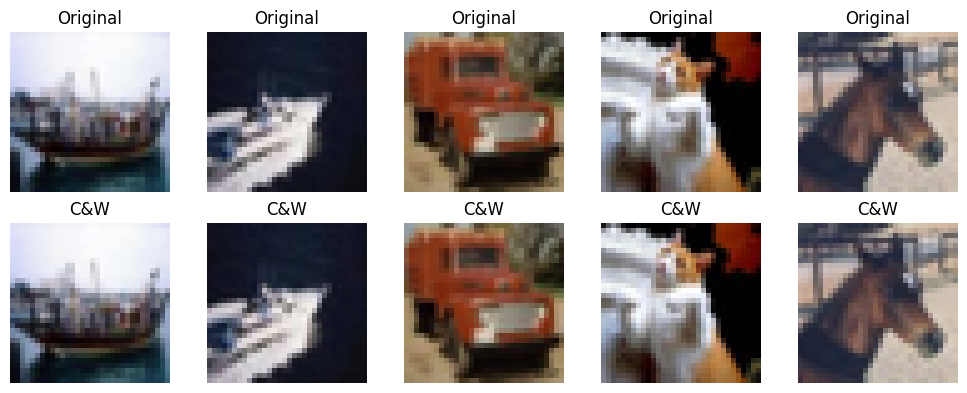

In [6]:


# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

#####################################
#           CONFIGURATION           
#####################################
model_name = "resnet20"  
# Possible values from chenyaofo/pytorch-cifar-models for CIFAR-10 include:
# - "cifar10_resnet20"
# - "cifar10_vgg16_bn"
# To switch to VGG16, set model_name = "vgg16_bn"

attack_batch_size = 200   # Batch size for generating adversarial examples
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

print("Using device:", device)

#####################################
#          DATA LOADING
#####################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),  # Mean for CIFAR-10
        (0.2470, 0.2435, 0.2616)   # Std for CIFAR-10
    )
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
print(f"Loaded {len(images)} test images.")

classes = test_dataset.classes

#####################################
#        MODEL LOADING
#####################################
# Load the chosen model from Torch Hub
if model_name == "resnet20":
    hub_model_name = 'cifar10_resnet20'
elif model_name == "vgg16_bn":
    hub_model_name = 'cifar10_vgg16_bn'
else:
    raise ValueError("Unsupported model name. Use 'resnet20' or 'vgg16_bn' for CIFAR-10.")

print(f"Loading {hub_model_name} model from Torch Hub...")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', hub_model_name, pretrained=True)
model.to(device)
model.eval()

#####################################
#       ART CLASSIFIER WRAPPER
#####################################
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

classifier_resnet = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device.type
)

print("Model wrapped in ART PyTorchClassifier.")

#####################################
#        ATTACK DEFINITIONS
#####################################
# FGSM attack
attack_fgsm_resnet20 = FastGradientMethod(estimator=classifier_resnet, eps=0.1)

# PGD attack
attack_pgd_resnet20 = ProjectedGradientDescent(estimator=classifier_resnet, eps=0.3, eps_step=0.1, max_iter=40)

# C&W attack: Reduced parameters to avoid extremely long runtimes
attack_cw_resnet20 = CarliniL2Method(
    classifier=classifier_resnet,
    max_iter=200,            # Reduce from 1000
    binary_search_steps=3,   # Reduce from 9
    confidence=0
)

#####################################
#     ADVERSARIAL EXAMPLE GENERATION
#####################################
def generate_adversarial_examples(attack, x_data, batch_size=200):
    """
    Generate adversarial examples in batches to prevent excessive runtime and memory issues.
    """
    adv_examples = []
    x_data_np = x_data.cpu().numpy()
    n = len(x_data_np)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch = x_data_np[start:end]
        adv = attack.generate(x=batch)
        adv_examples.append(adv)
    adv_examples = np.concatenate(adv_examples, axis=0)
    return adv_examples

print("\nGenerating adversarial examples using FGSM...")
x_test_adv_fgsm_resnet20 = attack_fgsm_resnet20.generate(x=images.cpu().numpy())

print("Generating adversarial examples using PGD...")
x_test_adv_pgd_resnet20 = attack_pgd_resnet20.generate(x=images.cpu().numpy())

print("Generating adversarial examples using Carlini & Wagner (L2)...")
x_test_adv_cw_resnet20 = generate_adversarial_examples(attack_cw_resnet20, images, batch_size=attack_batch_size)

print("Adversarial examples generated.")

#####################################
#        EVALUATION FUNCTIONS
#####################################
def evaluate_accuracy(classifier, x, y):
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    accuracy = np.mean(preds_labels == y)
    return accuracy

#####################################
#        EVALUATE MODEL
#####################################
y_true = labels.cpu().numpy()

print("\nEvaluating model performance:")
acc_clean_resnet20 = evaluate_accuracy(classifier_resnet, images.cpu().numpy(), y_true)
print(f"Accuracy on clean examples: {acc_clean_resnet20 * 100:.2f}%")

acc_fgsm_resnet20 = evaluate_accuracy(classifier_resnet, x_test_adv_fgsm_resnet20, y_true)
print(f"Accuracy on FGSM adversarial examples: {acc_fgsm_resnet20 * 100:.2f}%")

acc_pgd_resnet20 = evaluate_accuracy(classifier_resnet, x_test_adv_pgd_resnet20, y_true)
print(f"Accuracy on PGD adversarial examples: {acc_pgd_resnet20 * 100:.2f}%")

acc_cw_resnet20  = evaluate_accuracy(classifier_resnet, x_test_adv_cw_resnet20, y_true)
print(f"Accuracy on C&W adversarial examples: {acc_cw_resnet20 * 100:.2f}%")

# Save them to .npy files, to use later on
np.save("attack_fgsm_resnet20.npy", attack_fgsm_resnet20)
np.save("attack_pgd_resnet20.npy", attack_pgd_resnet20)
np.save("attack_cw_resnet20.npy", attack_cw_resnet20)
np.save("x_test_adv_fgsm_resnet20.npy", x_test_adv_fgsm_resnet20)
np.save("x_test_adv_pgd_resnet20.npy", x_test_adv_pgd_resnet20)
np.save("x_test_adv_cw_resnet20.npy", x_test_adv_cw_resnet20)

#####################################
#        SUMMARY
#####################################
print("\n=== SUMMARY OF RESULTS ===")
print(f"Model: {hub_model_name}")
print(f"Clean Accuracy: {acc_clean_resnet20 * 100:.2f}%")
print(f"FGSM Attack Accuracy: {acc_fgsm_resnet20 * 100:.2f}%")
print(f"PGD Attack Accuracy: {acc_pgd_resnet20 * 100:.2f}%")
print(f"C&W Attack Accuracy: {acc_cw_resnet20 * 100:.2f}%")

#####################################
#        OPTIONAL VISUALIZATION
#####################################
def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img * std.reshape(3,1,1) + mean.reshape(3,1,1)
    return np.clip(img, 0, 1)

def plot_adversarial_examples(original, adv, title,
                              num_examples=5,
                              labels_orig=None, 
                              preds_orig=None,
                              preds_adv=None):
    plt.figure(figsize=(10, 4))
    for i in range(num_examples):
        # Original Image
        plt.subplot(2, num_examples, i+1)
        plt.imshow(np.transpose(denormalize(original[i]), (1, 2, 0)))
        # If we have labels & predictions, show them
        if labels_orig is not None and preds_orig is not None:
            plt.title(f"Label: {labels_orig[i]}, Pred: {preds_orig[i]}")
        else:
            plt.title("Original")
        plt.axis('off')

        # Adversarial Image
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(np.transpose(denormalize(adv[i]), (1, 2, 0)))
        # If we have original labels & adv predictions, show them
        if labels_orig is not None and preds_adv is not None:
            plt.title(f"Label: {labels_orig[i]}, Pred: {preds_adv[i]}")
        else:
            plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a few examples
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]

# Get subset of true labels for these indices
y_subset = y_true[indices]

# Predict on the original subset
preds_original = classifier_resnet.predict(x_original)
preds_original_labels = np.argmax(preds_original, axis=1)

# 1) FGSM
x_fgsm_resnet20 = x_test_adv_fgsm_resnet20[indices]
preds_fgsm = classifier_resnet.predict(x_fgsm_resnet20)
preds_fgsm_labels = np.argmax(preds_fgsm, axis=1)
plot_adversarial_examples(x_original, 
                          x_fgsm_resnet20,
                          "FGSM",
                          num_examples=num_show,
                          labels_orig=y_subset, 
                          preds_orig=preds_original_labels,
                          preds_adv=preds_fgsm_labels)

# 2) PGD
x_pgd_resnet20 = x_test_adv_pgd_resnet20[indices]
preds_pgd = classifier_resnet.predict(x_pgd_resnet20)
preds_pgd_labels = np.argmax(preds_pgd, axis=1)
plot_adversarial_examples(x_original, 
                          x_pgd_resnet20,
                          "PGD",
                          num_examples=num_show,
                          labels_orig=y_subset, 
                          preds_orig=preds_original_labels,
                          preds_adv=preds_pgd_labels)

# 3) C&W
x_cw_resnet20 = x_test_adv_cw_resnet20[indices]
preds_cw = classifier_resnet.predict(x_cw_resnet20)
preds_cw_labels = np.argmax(preds_cw, axis=1)
plot_adversarial_examples(x_original, 
                          x_cw_resnet20,
                          "C&W",
                          num_examples=num_show,
                          labels_orig=y_subset, 
                          preds_orig=preds_original_labels,
                          preds_adv=preds_cw_labels)


# Visualize a few examples (optional)
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]
x_fgsm_resnet20 = x_test_adv_fgsm_resnet20[indices]
x_pgd_resnet20 = x_test_adv_pgd_resnet20[indices]
x_cw_resnet20 = x_test_adv_cw_resnet20[indices]

plot_adversarial_examples(x_original, x_fgsm_resnet20, "FGSM")
plot_adversarial_examples(x_original, x_pgd_resnet20, "PGD")
plot_adversarial_examples(x_original, x_cw_resnet20, "C&W")




Using device: cpu
Files already downloaded and verified
Loaded 1000 test images.
Loading cifar10_vgg16_bn model from Torch Hub...


Using cache found in C:\Users\mtm30/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Model wrapped in ART PyTorchClassifier.

Generating adversarial examples using FGSM...
Generating adversarial examples using PGD...


Generating adversarial examples using Carlini & Wagner (L2)...


C&W L_2: 100%|██████████| 200/200 [2:06:10<00:00, 37.85s/it]  


Adversarial examples generated.

Evaluating model performance:
Accuracy on clean examples: 92.80%
Accuracy on FGSM adversarial examples: 45.00%
Accuracy on PGD adversarial examples: 4.10%
Accuracy on C&W adversarial examples: 69.40%

=== SUMMARY OF RESULTS ===
Model: cifar10_vgg16_bn
Clean Accuracy: 92.80%
FGSM Attack Accuracy: 45.00%
PGD Attack Accuracy: 4.10%
C&W Attack Accuracy: 69.40%


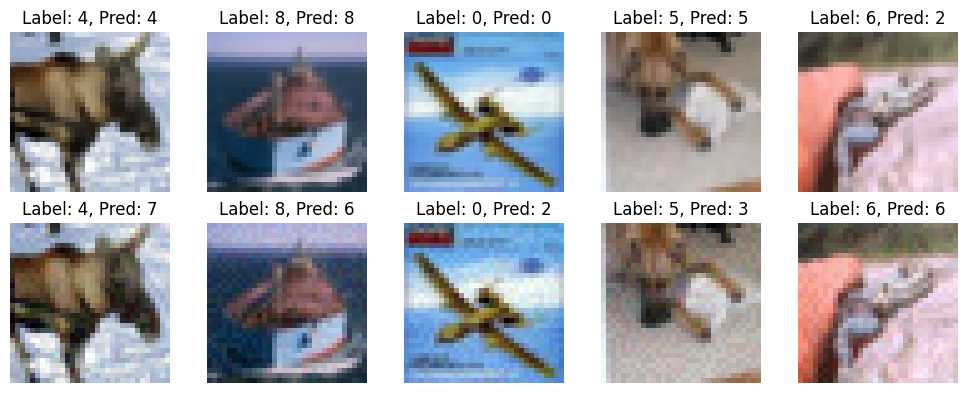

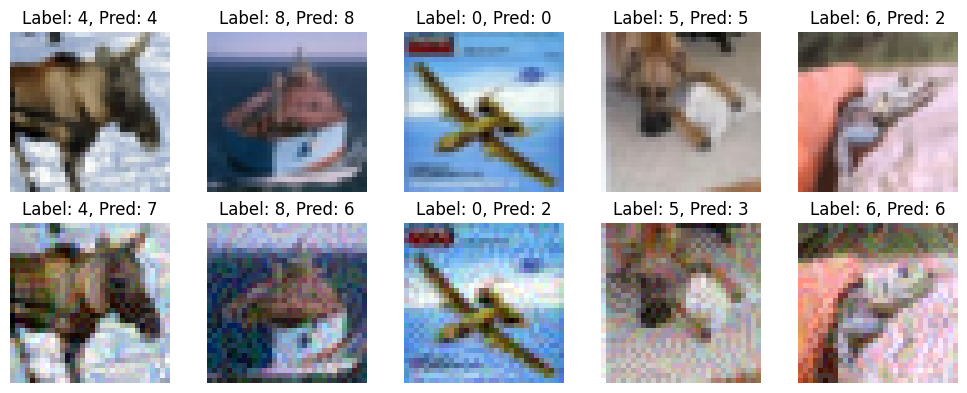

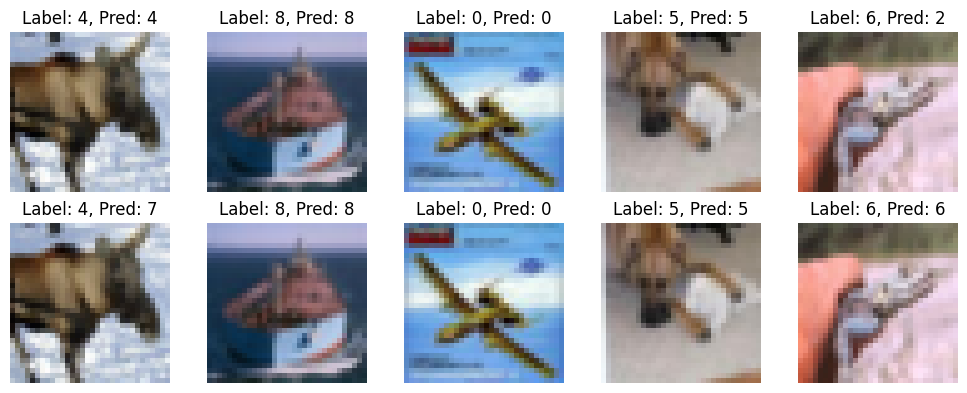

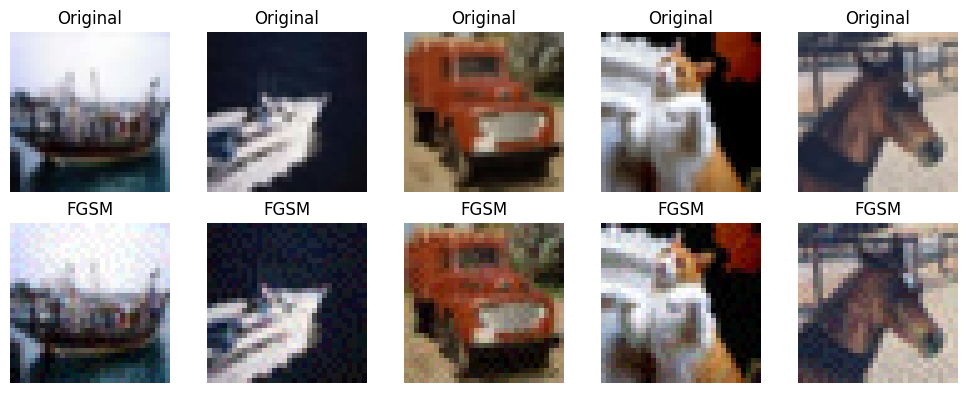

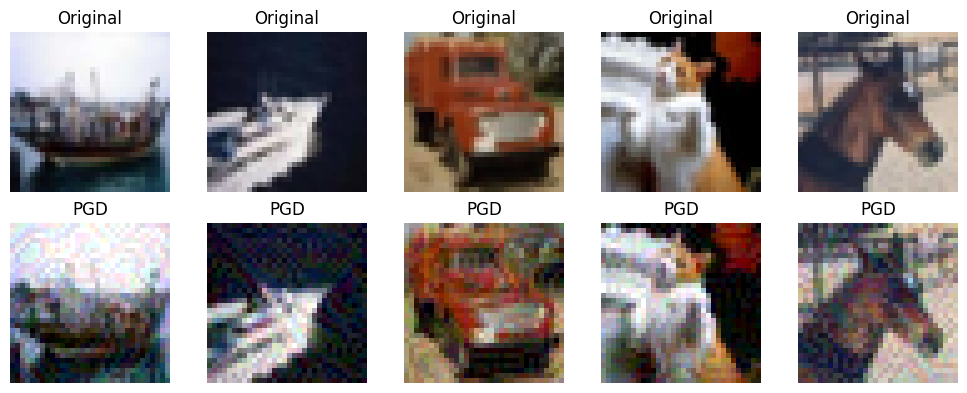

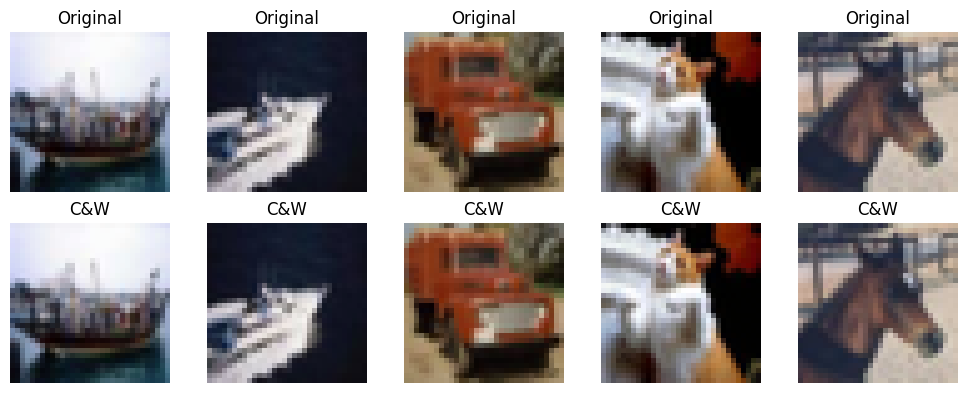

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

#####################################
#           CONFIGURATION
#####################################
model_name = "vgg16_bn"  
# Possible values from chenyaofo/pytorch-cifar-models for CIFAR-10 include:
# - "cifar10_resnet20"
# - "cifar10_vgg16_bn"
# To switch to VGG16, set model_name = "vgg16_bn"

attack_batch_size = 200   # Batch size for generating adversarial examples
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

print("Using device:", device)

#####################################
#          DATA LOADING
#####################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),  # Mean for CIFAR-10
        (0.2470, 0.2435, 0.2616)   # Std for CIFAR-10
    )
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
print(f"Loaded {len(images)} test images.")

classes = test_dataset.classes

#####################################
#        MODEL LOADING
#####################################
# Load the chosen model from Torch Hub
if model_name == "resnet20":
    hub_model_name = 'cifar10_resnet20'
elif model_name == "vgg16_bn":
    hub_model_name = 'cifar10_vgg16_bn'
else:
    raise ValueError("Unsupported model name. Use 'resnet20' or 'vgg16_bn' for CIFAR-10.")

print(f"Loading {hub_model_name} model from Torch Hub...")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', hub_model_name, pretrained=True)
model.to(device)
model.eval()

#####################################
#       ART CLASSIFIER WRAPPER
#####################################
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

classifier_vgg16_bn = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device.type
)

print("Model wrapped in ART PyTorchClassifier.")

#####################################
#        ATTACK DEFINITIONS
#####################################
# FGSM attack
attack_fgsm_vgg16 = FastGradientMethod(estimator=classifier_vgg16_bn, eps=0.1)

# PGD attack
attack_pgd_vgg16 = ProjectedGradientDescent(estimator=classifier_vgg16_bn, eps=0.3, eps_step=0.1, max_iter=40)

# C&W attack: Reduced parameters to avoid extremely long runtimes
attack_cw_vgg16 = CarliniL2Method(
    classifier=classifier_vgg16_bn,
    max_iter=200,            # Reduce from 1000
    binary_search_steps=3,   # Reduce from 9
    confidence=0
)

#####################################
#     ADVERSARIAL EXAMPLE GENERATION
#####################################
def generate_adversarial_examples(attack, x_data, batch_size=200):
    """
    Generate adversarial examples in batches to prevent excessive runtime and memory issues.
    """
    adv_examples = []
    x_data_np = x_data.cpu().numpy()
    n = len(x_data_np)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch = x_data_np[start:end]
        adv = attack.generate(x=batch)
        adv_examples.append(adv)
    adv_examples = np.concatenate(adv_examples, axis=0)
    return adv_examples

print("\nGenerating adversarial examples using FGSM...")
x_test_adv_fgsm_vgg16 = attack_fgsm_vgg16.generate(x=images.cpu().numpy())

print("Generating adversarial examples using PGD...")
x_test_adv_pgd_vgg16 = attack_pgd_vgg16.generate(x=images.cpu().numpy())

print("Generating adversarial examples using Carlini & Wagner (L2)...")
x_test_adv_cw_vgg16 = generate_adversarial_examples(attack_cw_vgg16, images, batch_size=attack_batch_size)

print("Adversarial examples generated.")

#####################################
#        EVALUATION FUNCTIONS
#####################################
def evaluate_accuracy(classifier, x, y):
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    accuracy = np.mean(preds_labels == y)
    return accuracy

#####################################
#        EVALUATE MODEL
#####################################
y_true = labels.cpu().numpy()

print("\nEvaluating model performance:")
acc_clean_vgg16 = evaluate_accuracy(classifier_vgg16_bn, images.cpu().numpy(), y_true)
print(f"Accuracy on clean examples: {acc_clean_vgg16 * 100:.2f}%")

acc_fgsm_vgg16 = evaluate_accuracy(classifier_vgg16_bn, x_test_adv_fgsm_vgg16, y_true)
print(f"Accuracy on FGSM adversarial examples: {acc_fgsm_vgg16 * 100:.2f}%")

acc_pgd_vgg16 = evaluate_accuracy(classifier_vgg16_bn, x_test_adv_pgd_vgg16, y_true)
print(f"Accuracy on PGD adversarial examples: {acc_pgd_vgg16 * 100:.2f}%")

acc_cw_vgg16 = evaluate_accuracy(classifier_vgg16_bn, x_test_adv_cw_vgg16, y_true)
print(f"Accuracy on C&W adversarial examples: {acc_cw_vgg16 * 100:.2f}%")


# Save them to .npy files
np.save("attack_fgsm_vgg16.npy", attack_fgsm_vgg16)
np.save("attack_pgd_vgg16.npy", attack_pgd_vgg16)
np.save("attack_cw_vgg16.npy", attack_cw_vgg16)
np.save("x_test_adv_fgsm_vgg16.npy", x_test_adv_fgsm_vgg16)
np.save("x_test_adv_pgd_vgg16.npy", x_test_adv_pgd_vgg16)
np.save("x_test_adv_cw_vgg16.npy", x_test_adv_cw_vgg16)


#####################################
#        SUMMARY
#####################################
print("\n=== SUMMARY OF RESULTS ===")
print(f"Model: {hub_model_name}")
print(f"Clean Accuracy: {acc_clean_vgg16 * 100:.2f}%")
print(f"FGSM Attack Accuracy: {acc_fgsm_vgg16 * 100:.2f}%")
print(f"PGD Attack Accuracy: {acc_pgd_vgg16 * 100:.2f}%")
print(f"C&W Attack Accuracy: {acc_cw_vgg16 * 100:.2f}%")


#####################################
#        OPTIONAL VISUALIZATION
#####################################
def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img * std.reshape(3,1,1) + mean.reshape(3,1,1)
    return np.clip(img, 0, 1)

def plot_adversarial_examples(original, adv, title,
                              num_examples=5,
                              labels_orig=None,
                              preds_orig=None,
                              preds_adv=None):
    """
    Plots original vs. adversarial images side by side.
    If labels and predictions are provided, each subplot's title
    will show 'Label: X, Pred: Y'.
    """
    plt.figure(figsize=(10, 4))
    for i in range(num_examples):
        # --- Original image ---
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(np.transpose(denormalize(original[i]), (1, 2, 0)))
        if labels_orig is not None and preds_orig is not None:
            plt.title(f"Label: {labels_orig[i]}, Pred: {preds_orig[i]}")
        else:
            plt.title("Original")
        plt.axis('off')

        # --- Adversarial image ---
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(np.transpose(denormalize(adv[i]), (1, 2, 0)))
        if labels_orig is not None and preds_adv is not None:
            plt.title(f"Label: {labels_orig[i]}, Pred: {preds_adv[i]}")
        else:
            plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Select a few random examples to visualize
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]
y_subset = y_true[indices]

# Predict on the original subset
preds_original = classifier_vgg16_bn.predict(x_original)
preds_original_labels = np.argmax(preds_original, axis=1)

# 1) FGSM
x_fgsm_vgg16 = x_test_adv_fgsm_vgg16[indices]
preds_fgsm = classifier_vgg16_bn.predict(x_fgsm_vgg16)
preds_fgsm_labels = np.argmax(preds_fgsm, axis=1)
plot_adversarial_examples(
    x_original,
    x_fgsm_vgg16,
    "FGSM",
    num_examples=num_show,
    labels_orig=y_subset,
    preds_orig=preds_original_labels,
    preds_adv=preds_fgsm_labels
)

# 2) PGD
x_pgd_vgg16 = x_test_adv_pgd_vgg16[indices]
preds_pgd = classifier_vgg16_bn.predict(x_pgd_vgg16)
preds_pgd_labels = np.argmax(preds_pgd, axis=1)
plot_adversarial_examples(
    x_original,
    x_pgd_vgg16,
    "PGD",
    num_examples=num_show,
    labels_orig=y_subset,
    preds_orig=preds_original_labels,
    preds_adv=preds_pgd_labels
)

# 3) C&W
x_cw_vgg16 = x_test_adv_cw_vgg16[indices]
preds_cw = classifier_vgg16_bn.predict(x_cw_vgg16)
preds_cw_labels = np.argmax(preds_cw, axis=1)
plot_adversarial_examples(
    x_original,
    x_cw_vgg16,
    "C&W",
    num_examples=num_show,
    labels_orig=y_subset,
    preds_orig=preds_original_labels,
    preds_adv=preds_cw_labels
)


# Visualize a few examples (optional)
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]
x_fgsm_vgg16 = x_test_adv_fgsm_vgg16[indices]
x_pgd_vgg16 = x_test_adv_pgd_vgg16[indices]
x_cw_vgg16 = x_test_adv_cw_vgg16[indices]

plot_adversarial_examples(x_original, x_fgsm_vgg16, "FGSM")
plot_adversarial_examples(x_original, x_pgd_vgg16, "PGD")
plot_adversarial_examples(x_original, x_cw_vgg16, "C&W")





Classification Report - FGSM Adversarial Examples:
              precision    recall  f1-score   support

    airplane       0.26      0.50      0.34        14
  automobile       0.92      0.53      0.68        43
        bird       0.67      0.72      0.69       117
         cat       0.89      0.65      0.75       171
        deer       0.81      0.53      0.64        91
        frog       0.61      0.94      0.74       139
       horse       0.97      0.76      0.86       102
        ship       0.76      0.97      0.85       157
       truck       0.86      0.75      0.80       166

    accuracy                           0.76      1000
   macro avg       0.75      0.71      0.71      1000
weighted avg       0.79      0.76      0.76      1000


Classification Report - PGD Adversarial Examples:
              precision    recall  f1-score   support

    airplane       0.14      0.36      0.20        14
  automobile       0.44      0.16      0.24        43
        bird       0.44      

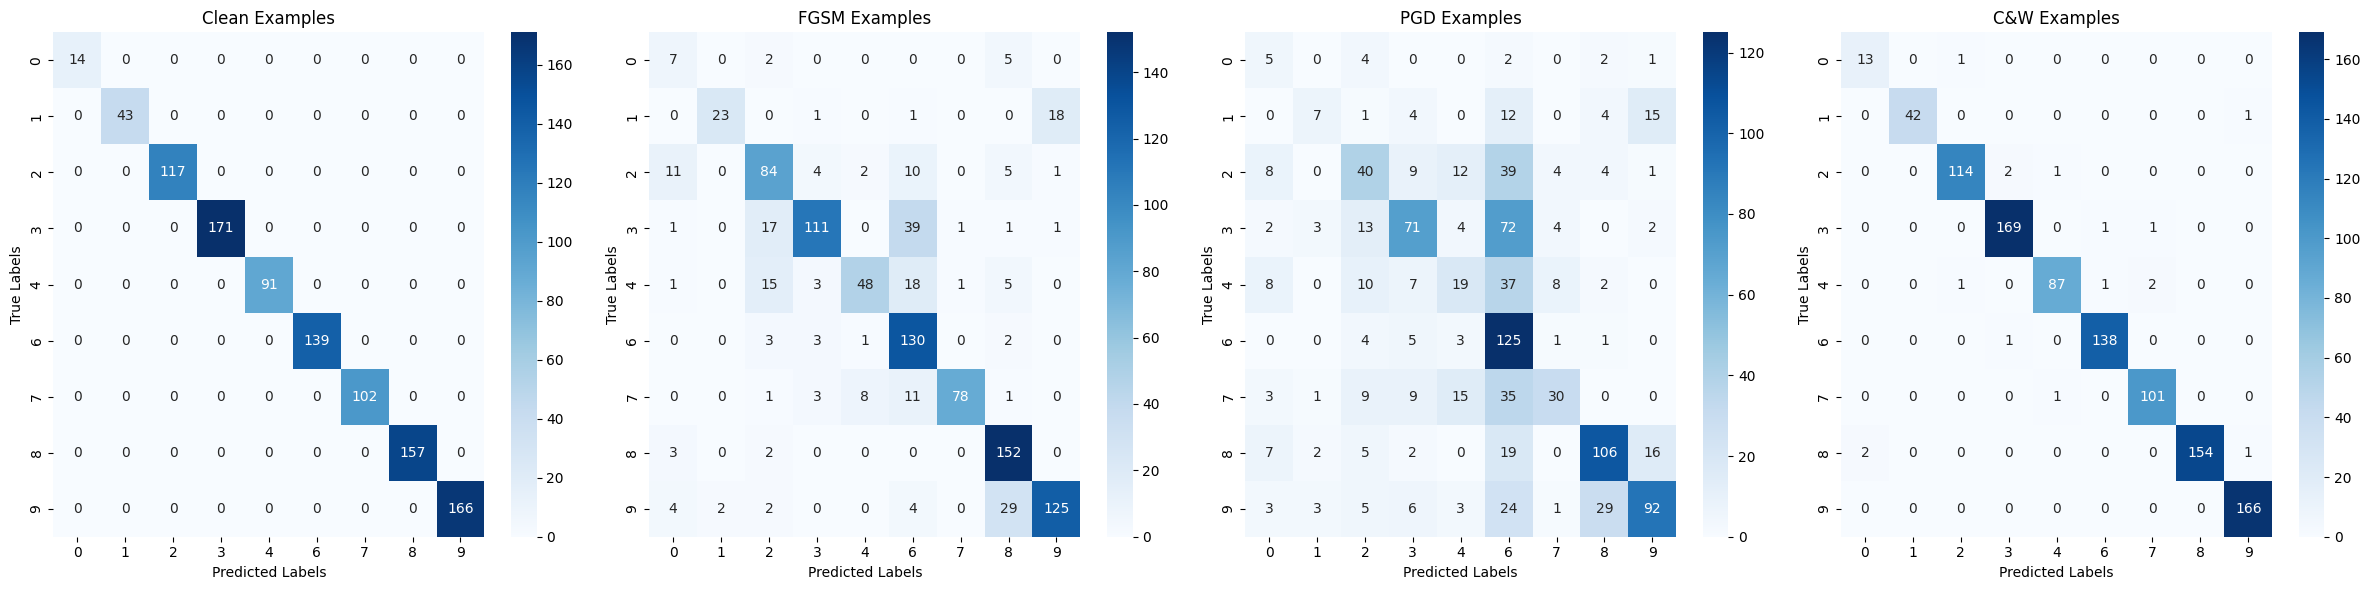

In [22]:
# Dynamically determine unique labels from y_true or predictions
unique_classes_vgg = np.unique(y_true)

# Generate clean predictions
y_pred_clean_vgg = np.argmax(classifier_vgg16_bn.predict(images.cpu().numpy()), axis=1)

# Generate confusion matrix for clean examples
cm_clean_vgg = confusion_matrix(y_true, y_pred_clean_vgg, labels=unique_classes_vgg)

# Evaluate adversarial examples and generate confusion matrices
confusion_matrices_vgg = [cm_clean_vgg]
titles_vgg = ["Clean Examples"]

for attack_name, adv_examples in [
    ("FGSM", x_test_adv_fgsm_vgg16),
    ("PGD", x_test_adv_pgd_vgg16),
    ("C&W", x_test_adv_cw_vgg16)
]:
    y_pred_adv_vgg = np.argmax(classifier_vgg16_bn.predict(adv_examples), axis=1)
    cm_adv_vgg = confusion_matrix(y_true, y_pred_adv_vgg, labels=unique_classes_vgg)
    confusion_matrices_vgg.append(cm_adv_vgg)
    titles_vgg.append(f"{attack_name} Examples")

    # Print classification report using unique classes
    print(f"\nClassification Report - {attack_name} Adversarial Examples:")
    print(classification_report(y_true, y_pred_adv_vgg, labels=unique_classes_vgg, target_names=[classes[i] for i in unique_classes_vgg]))

# Plot all confusion matrices side by side
plot_side_by_side_confusion_matrices(confusion_matrices_vgg, titles_vgg, unique_classes_vgg)


### Some observations about ResNet model

In [17]:
# Use clean predictions from ResNet as pseudo-labels
y_pred_clean_resnet = np.argmax(classifier_resnet.predict(images.cpu().numpy()), axis=1)

# Treat `y_pred_clean_resnet` as the reference labels for comparison
for attack_name, adv_examples in [
    ("FGSM", x_test_adv_fgsm_resnet20),
    ("PGD", x_test_adv_pgd_resnet20),
    ("C&W", x_test_adv_cw_resnet20),
]:
    y_pred_adv_resnet = np.argmax(classifier_resnet.predict(adv_examples), axis=1)
    
    # Compare clean predictions to adversarial predictions
    print(f"\nComparison - {attack_name} Adversarial Examples (ResNet):")
    print(f"Clean Predictions: {y_pred_clean_resnet[:10]}")
    print(f"Adversarial Predictions: {y_pred_adv_resnet[:10]}")



Comparison - FGSM Adversarial Examples (ResNet):
Clean Predictions: [3 8 8 8 6 6 1 7 3 1]
Adversarial Predictions: [4 8 9 8 6 6 1 6 6 9]

Comparison - PGD Adversarial Examples (ResNet):
Clean Predictions: [3 8 8 8 6 6 1 7 3 1]
Adversarial Predictions: [6 8 6 8 6 6 9 6 6 6]

Comparison - C&W Adversarial Examples (ResNet):
Clean Predictions: [3 8 8 8 6 6 1 7 3 1]
Adversarial Predictions: [3 8 8 8 6 7 1 7 3 1]



Classification Report - FGSM Adversarial Examples:
              precision    recall  f1-score   support

    airplane       0.29      0.50      0.36        12
  automobile       0.86      0.51      0.64       185
        bird       0.18      0.28      0.22        32
         cat       0.57      0.10      0.17       230
        deer       0.23      0.33      0.27        48
         dog       0.10      0.14      0.11        14
        frog       0.18      0.99      0.31        76
       horse       0.92      0.18      0.30       190
        ship       0.58      0.78      0.67        68
       truck       0.60      0.62      0.61       145

    accuracy                           0.40      1000
   macro avg       0.45      0.44      0.37      1000
weighted avg       0.63      0.40      0.40      1000


Classification Report - PGD Adversarial Examples:
              precision    recall  f1-score   support

    airplane       0.14      0.08      0.11        12
  automobile       0.80      

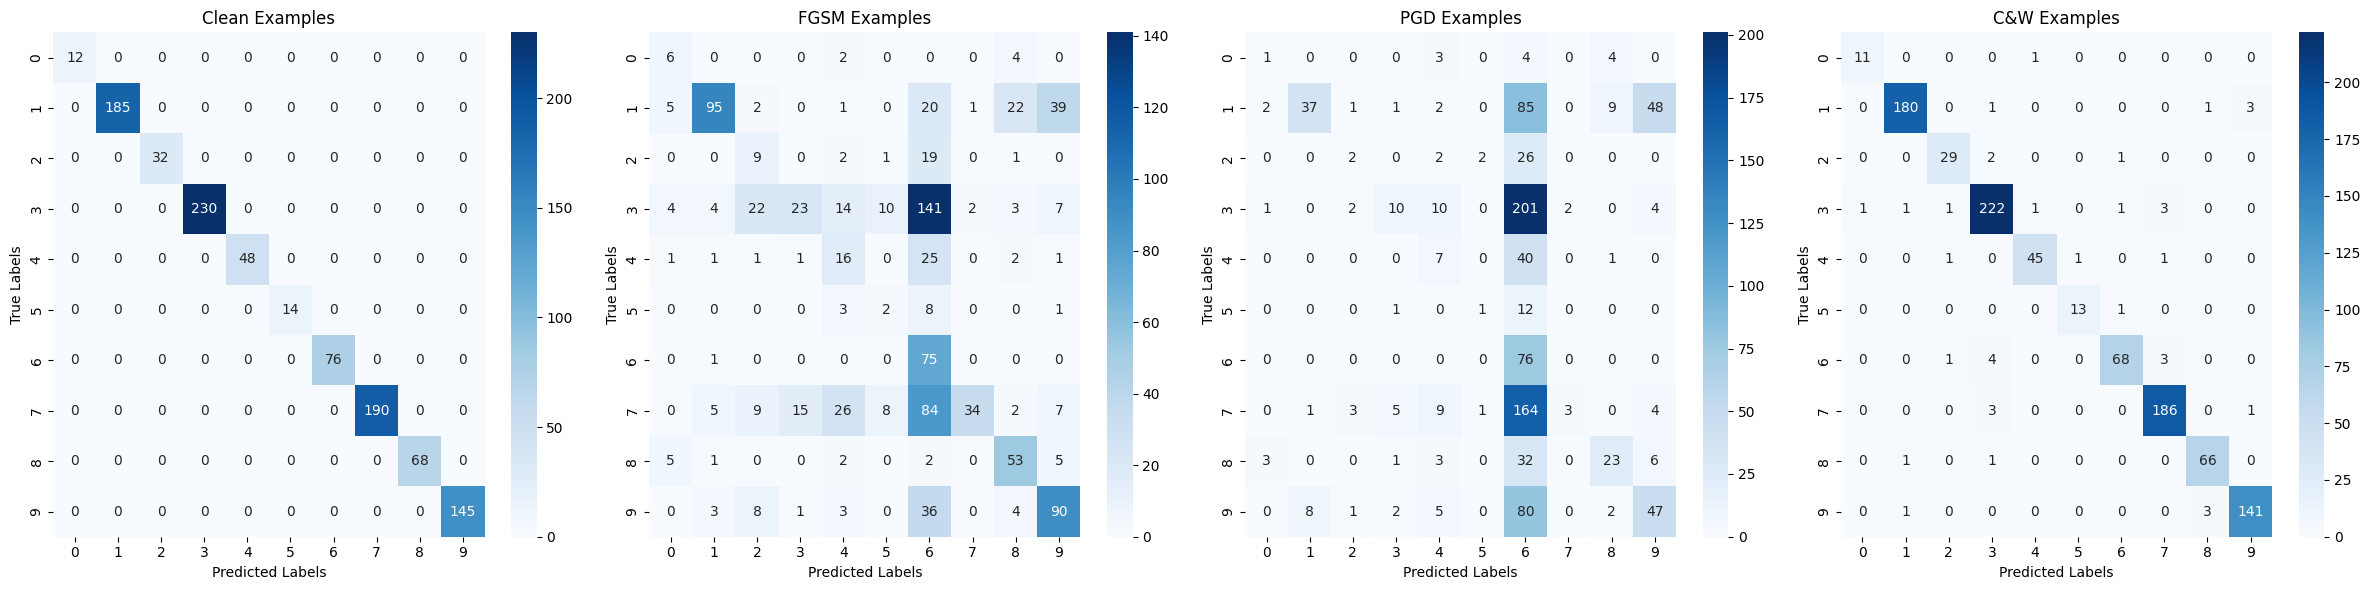

In [19]:
#####################################
#         PERFORMANCE ANALYSIS
#####################################
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Ensure labels are dynamically aligned with the dataset
unique_labels = np.unique(y_pred_clean_resnet)  # Using predictions from clean examples as pseudo-labels

# Generate clean predictions to use as pseudo ground-truth labels
y_pred_clean_resnet = np.argmax(classifier_resnet.predict(images.cpu().numpy()), axis=1)

# Generate confusion matrix for clean examples
cm_clean = confusion_matrix(y_pred_clean_resnet, y_pred_clean_resnet, labels=unique_labels)

# Evaluate adversarial examples and generate confusion matrices
confusion_matrices = [cm_clean]
titles = ["Clean Examples"]

for attack_name, adv_examples in [
    ("FGSM", x_test_adv_fgsm_resnet20),
    ("PGD", x_test_adv_pgd_resnet20),
    ("C&W", x_test_adv_cw_resnet20)
]:
    y_pred_adv_resnet = np.argmax(classifier_resnet.predict(adv_examples), axis=1)
    cm_adv = confusion_matrix(y_pred_clean_resnet, y_pred_adv_resnet, labels=unique_labels)
    confusion_matrices.append(cm_adv)
    titles.append(f"{attack_name} Examples")

    # Print classification report
    print(f"\nClassification Report - {attack_name} Adversarial Examples:")
    print(classification_report(y_pred_clean_resnet, y_pred_adv_resnet, target_names=classes))

# Plot all confusion matrices side by side
plot_side_by_side_confusion_matrices(confusion_matrices, titles, unique_labels)


### Some observations about VGG16 model

In [ ]:
# Use clean predictions from VGG16 as pseudo-labels
y_pred_clean_vgg16 = np.argmax(classifier_vgg16_bn.predict(images.cpu().numpy()), axis=1)

# Treat `y_pred_clean_vgg16` as the reference labels for comparison
for attack_name, adv_examples in [
    ("FGSM", x_test_adv_fgsm_vgg16),
    ("PGD", x_test_adv_pgd_vgg16),
    ("C&W", x_test_adv_cw_vgg16),
]:
    y_pred_adv_vgg16 = np.argmax(classifier_vgg16_bn.predict(adv_examples), axis=1)
    
    # Compare clean predictions to adversarial predictions
    print(f"\nComparison - {attack_name} Adversarial Examples (VGG16):")
    print(f"Clean Predictions: {y_pred_clean_vgg16[:10]}")
    print(f"Adversarial Predictions: {y_pred_adv_vgg16[:10]}")


### implementing defensive techniques

In [8]:
from art.defences.trainer import AdversarialTrainer

# Adversarial training using FGSM, PGD, and C&W for VGG16
adv_trainer = AdversarialTrainer(classifier_vgg16_bn, attacks=[attack_fgsm_vgg16, attack_pgd_vgg16, attack_cw_vgg16])
adv_trainer.fit(images.cpu().numpy(), labels.cpu().numpy(), nb_epochs=3)

# Evaluate the robustly trained model
print("\nEvaluating adversarially trained model performance:")
acc_clean_adv_vgg16 = evaluate_accuracy(adv_trainer.get_classifier(), images.cpu().numpy(), y_true)
print(f"Robust Model Accuracy on clean examples: {acc_clean_adv_vgg16 * 100:.2f}%")

acc_fgsm_adv_vgg16 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_fgsm_vgg16, y_true)
print(f"Robust Model Accuracy on FGSM adversarial examples: {acc_fgsm_adv_vgg16 * 100:.2f}%")

acc_pgd_adv_vgg16 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_pgd_vgg16, y_true)
print(f"Robust Model Accuracy on PGD adversarial examples: {acc_pgd_adv_vgg16 * 100:.2f}%")

acc_cw_adv_vgg16 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_cw_vgg16, y_true)
print(f"Robust Model Accuracy on C&W adversarial examples: {acc_cw_adv_vgg16 * 100:.2f}%")


Adversarial training epochs: 100%|██████████| 3/3 [5:21:39<00:00, 6433.01s/it]  



Evaluating adversarially trained model performance:
Robust Model Accuracy on clean examples: 71.80%
Robust Model Accuracy on FGSM adversarial examples: 56.70%
Robust Model Accuracy on PGD adversarial examples: 34.70%
Robust Model Accuracy on C&W adversarial examples: 71.40%


In [9]:
from art.defences.trainer import AdversarialTrainer

# Adversarial training using FGSM, PGD, and C&W for ResNet20
adv_trainer = AdversarialTrainer(classifier_resnet, attacks=[attack_fgsm_resnet20, attack_pgd_resnet20, attack_cw_resnet20])
adv_trainer.fit(images.cpu().numpy(), labels.cpu().numpy(), nb_epochs=3)

# Evaluate the robustly trained model
print("\nEvaluating adversarially trained model performance:")
acc_clean_adv_resnet20 = evaluate_accuracy(adv_trainer.get_classifier(), images.cpu().numpy(), y_true)
print(f"Robust Model Accuracy on clean examples: {acc_clean_adv_resnet20 * 100:.2f}%")

acc_fgsm_adv_resnet20 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_fgsm_resnet20, y_true)
print(f"Robust Model Accuracy on FGSM adversarial examples: {acc_fgsm_adv_resnet20 * 100:.2f}%")

acc_pgd_adv_resnet20 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_pgd_resnet20, y_true)
print(f"Robust Model Accuracy on PGD adversarial examples: {acc_pgd_adv_resnet20 * 100:.2f}%")

acc_cw_adv_resnet20 = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_cw_resnet20, y_true)
print(f"Robust Model Accuracy on C&W adversarial examples: {acc_cw_adv_resnet20 * 100:.2f}%")


Adversarial training epochs: 100%|██████████| 3/3 [3:37:20<00:00, 4346.73s/it]  



Evaluating adversarially trained model performance:
Robust Model Accuracy on clean examples: 57.40%
Robust Model Accuracy on FGSM adversarial examples: 44.10%
Robust Model Accuracy on PGD adversarial examples: 22.50%
Robust Model Accuracy on C&W adversarial examples: 56.20%
